## Collaborative Filtering on MovieLens 10M dataset
Authors: (USRMODL S12)
- Christopher Lim
- Kyle Kenneth Chua
- Jethro Tsai

## Importing the Libraries

Loading the necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

import warnings
warnings.filterwarnings('ignore')

Loading the data preparation and model evaluation libraries

In [4]:
from metrics import rmse

import time

## Importing the Datasets

In [5]:
movies = pd.read_csv('./input/movie.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings = pd.read_csv('./input/rating.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [7]:
df = movies.merge(ratings, how="left", on="movieId")
df.head()

del movies
del ratings

## Exploratory Data Analysis

### Columns

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000797 entries, 0 to 20000796
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   title      object 
 2   genres     object 
 3   userId     float64
 4   rating     float64
 5   timestamp  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.0+ GB


In [9]:
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()
mean_num_ratings = df.groupby('userId').count()['movieId'].mean()

print('Number of users:', n_users)   # 5000
print('Number of movies:', n_movies) # 1000
print('Number of ratings:', len(df))
print('Average number of ratings per user:', mean_num_ratings)

Number of users: 138493
Number of movies: 27278
Number of ratings: 20000797
Average number of ratings per user: 144.4135299257002


<AxesSubplot:xlabel='userId'>

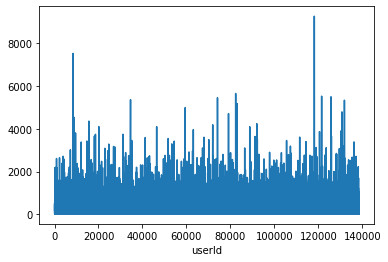

In [10]:
df.groupby('userId').count()['movieId'].plot()

<AxesSubplot:xlabel='movieId'>

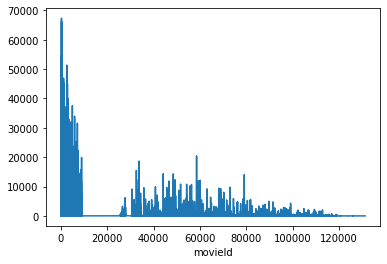

In [11]:
df.groupby('movieId').count()['userId'].plot()

In [12]:
print('Min Rating:', df['rating'].min())
print('Max Rating:', df['rating'].max())

Min Rating: 0.5
Max Rating: 5.0


## Data Preprocessing

### Drop missing user ids

In [13]:
df = df.dropna(subset=["userId"], axis=0)
len(df)

20000263

### Removes `genres`, `timestamp`, and `title` column

In [14]:
# Remove column name 'genres', 'timestamp' and 'title'
df = df.drop(['genres', 'timestamp', 'title'], axis=1)
df['userId'] = df['userId'].astype(int)
df.head()

,movieId,userId,rating
0,1,3,4.0
1,1,6,5.0
2,1,8,4.0
3,1,10,4.0
4,1,11,4.5


### Filter to top 1,000 movies and top 1,000 users

In [15]:
n_users = 1000
n_movies = 1000

In [16]:
titles = df['movieId'].value_counts().head(n_movies).index # top  1,000 most-rated movies
users = df['userId'].value_counts().head(n_users).index  # top 1,000 users with the most number of ratings

top_df = df[(df['movieId'].isin(titles) & df['userId'].isin(users))]
top_df.head()

,movieId,userId,rating
56,1,156,5.0
71,1,208,4.0
123,1,359,5.0
186,1,572,5.0
190,1,586,2.5


In [17]:
print('Number of users:', top_df['userId'].nunique())
print('Number of movies:', top_df['movieId'].nunique()) 
print('Number of ratings:', len(top_df))
print('Average number of ratings per user:', top_df.groupby('userId').count()['movieId'].mean())

Number of users: 1000
Number of movies: 1000
Number of ratings: 627078
Average number of ratings per user: 627.078


#### Convert table format into user-item matrix (utility matrix) format 

In [18]:
top_um= top_df.pivot_table(index=["userId"], columns=["movieId"], values="rating").to_numpy(dtype=np.float32, na_value=0)
sparsity = (1.0 - np.count_nonzero(top_um) / top_um.size) * 100

print('Shape:', top_um.shape)
print('Sparsity: %.2f%%' % sparsity)

Shape: (1000, 1000)
Sparsity: 37.29%


### Filter to top 1,000 movies and 1,000 random users

In [19]:
titles = df['movieId'].value_counts().head(n_movies).index # top  1,000 most-rated movies
users = df.groupby('userId').count().sample(n=n_users, random_state=0).index

random_df = df[df['movieId'].isin(titles)][df['userId'].isin(users)]
random_df.head()

del df

In [20]:
print('Number of users:', random_df['userId'].nunique())
print('Number of movies:', random_df['movieId'].nunique())
print('Number of ratings:', len(random_df))
print('Average number of ratings per user:', random_df.groupby('userId').count()['movieId'].mean())

Number of users: 1000
Number of movies: 1000
Number of ratings: 97366
Average number of ratings per user: 97.366


#### Convert table format into user-item matrix (utility matrix) format 

In [21]:
random_um= random_df.pivot_table(index=["userId"], columns=["movieId"], values="rating").to_numpy(dtype=np.float32, na_value=0)
sparsity = (1.0 - np.count_nonzero(random_um) / random_um.size) * 100

print('Shape:', random_um.shape)
print('Sparsity: %.2f%%' % sparsity)

Shape: (1000, 1000)
Sparsity: 90.26%


### Get MSE on avg rating per user and avg rating per movie

In [22]:
utility_matrices = [top_um, random_um]

for um in utility_matrices:
    average_rating_per_user = [np.mean(row[row > 0]) for row in um]
    print('MSE based on average user rating:', np.sum([np.sum(np.square(row[row > 0] - average_rating_per_user[i])) for i, row in enumerate(um)]) / len(um[um > 0]))
    
    average_rating_per_movie = [np.mean(column[column > 0]) for column in um.T]
    print('MSE based on average movie rating:', np.sum([np.sum(np.square(column[column > 0] - average_rating_per_user[i])) for i, column in enumerate(um.T)]) / len(um[um > 0]))
    
    print('Unique values:', np.unique(um))
    print('-' * 20)

MSE based on average user rating: 0.8692040703070432
MSE based on average movie rating: 1.184244324470002
Unique values: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
--------------------
MSE based on average user rating: 0.8742411846794569
MSE based on average movie rating: 1.2724553809851489
Unique values: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
--------------------


### Function to convert utility matrix ratings from original user ratings 0 until 5 to normalized user ratings 0 until 1

In [23]:
def convert_to_normalized_matrix(ratings):
    copy = np.copy(ratings)
    copy = copy / 5
    
    return copy

### Function to convert utility matrix ratings from 0 until 5 to -1 until 1 
[0] values means missing values to be converted to -1  
[0.5, 1, 1.5, 2] values means low ratings to be converted to 0 (labeled as bad ratings)  
[2.5, 3, 3.5, 4, 4.5, 5] values means high ratings to be converted to 1 (labeled as good ratings)

In [24]:
def convert_to_recommendation_matrix(ratings):
    copy = np.copy(ratings)
    copy[copy <= 0] = -1
    copy[(copy > 0) & (copy < 3)] = 0
    copy[(copy >= 3)] = 1
    
    return copy

## Models

### Matrix Factorization/UV Decomposition Model

#### Importing the Matrix Factorization Model

In [22]:
from matrix_factorization import MF

#### Training

In [24]:
training_results = []
mf_models = []

for i in range(len(utility_matrices)):
    # Initialize the Matrix Factorization model
    mf = MF(utility_matrices[i], 3, alpha=0.005, beta=0.002, iterations=150)
    
    start = time.perf_counter()
    
    # Trains the model
    training_result = mf.train()
    
    end = time.perf_counter()
    
    print('Time it took to train: %.4fs' % (end - start))
    
    # Stores the model
    mf_models.append(mf)
    
    # Stores the results
    training_results.append(training_result)

Epoch: 1 ; error = 0.6694
Epoch: 2 ; error = 0.6604
Epoch: 3 ; error = 0.6566
Epoch: 4 ; error = 0.6523
Epoch: 5 ; error = 0.6435
Epoch: 6 ; error = 0.6275
Epoch: 7 ; error = 0.6111
Epoch: 8 ; error = 0.6019
Epoch: 9 ; error = 0.5972
Epoch: 10 ; error = 0.5938
Epoch: 11 ; error = 0.5907
Epoch: 12 ; error = 0.5878
Epoch: 13 ; error = 0.5851
Epoch: 14 ; error = 0.5824
Epoch: 15 ; error = 0.5800
Epoch: 16 ; error = 0.5780
Epoch: 17 ; error = 0.5763
Epoch: 18 ; error = 0.5749
Epoch: 19 ; error = 0.5737
Epoch: 20 ; error = 0.5728
Epoch: 21 ; error = 0.5719
Epoch: 22 ; error = 0.5711
Epoch: 23 ; error = 0.5704
Epoch: 24 ; error = 0.5697
Epoch: 25 ; error = 0.5689
Epoch: 26 ; error = 0.5683
Epoch: 27 ; error = 0.5676
Epoch: 28 ; error = 0.5670
Epoch: 29 ; error = 0.5662
Epoch: 30 ; error = 0.5657
Epoch: 31 ; error = 0.5650
Epoch: 32 ; error = 0.5643
Epoch: 33 ; error = 0.5638
Epoch: 34 ; error = 0.5633
Epoch: 35 ; error = 0.5628
Epoch: 36 ; error = 0.5625
Epoch: 37 ; error = 0.5621
Epoch: 38 

#### Visualizing the training errors

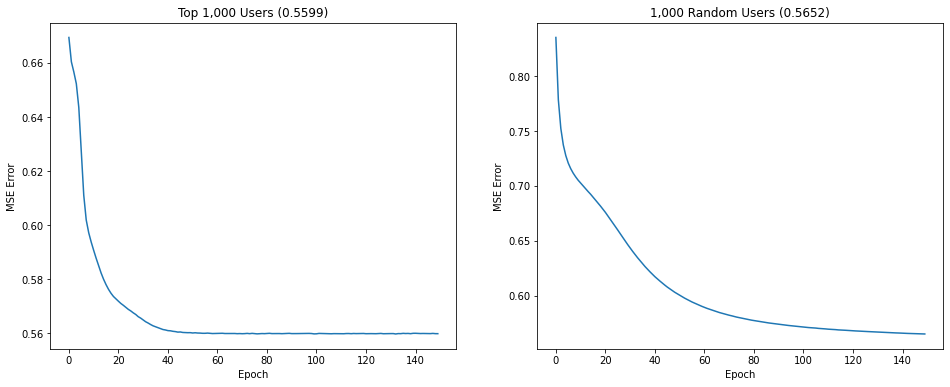

In [51]:
fig = plt.figure(figsize=(16, 6))
titles = ['Top 1,000 Users', '1,000 Random Users']

row = 1
col = 2

for i in range(len(utility_matrices)):
    # Adds a subplot at the 1st position
    fig.add_subplot(row, col, i + 1)
    pd.Series(training_results[i]).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(titles[i] + (' (%.4f)' % (training_results[i][-1])))

plt.show()

#### Saving the models
Save the models so that it doesn't have to be trained again.

In [28]:
# models will be saved on a .pkl format (pickle files)
filenames = ['./output/top_mf_model.pkl', './output/random_mf_model.pkl']

for i in range(len(filenames)):
    pickle.dump(mf_models[i], open(filenames[i], 'wb'))

In [23]:
# loading the saved UV decomposition model
mf_models = []
filenames = ['./output/top_mf_model.pkl', './output/random_mf_model.pkl']

for filename in filenames:
    mf_models.append(pickle.load(open(filename, 'rb')))

#### Recommender System Simulation

In [24]:
for i in range(len(mf_models)):
    predicted_recommendations = convert_to_recommendation_matrix(mf_models[i].full_matrix())
    actual_recommendations = convert_to_recommendation_matrix(utility_matrices[i])
    
    print(np.unique(predicted_recommendations))
    print(np.unique(actual_recommendations))
    print('RMSE: %.4f' % rmse(actual_recommendations, predicted_recommendations))
    print('=' * 20)

[-1.  0.  1.]
[-1.  0.  1.]
Mean squared error: 0.4218
[-1.  0.  1.]
[-1.  0.  1.]
Mean squared error: 0.3700


### Random Boltzmann Machine Models

#### Importing the RBM Model

In [23]:
from rbm import RBM

Instructions for updating:
non-resource variables are not supported in the long term


#### Training the RBM Model

In [24]:
data = []

for um in utility_matrices:
    # Define the parameters of the RBMs we will train
    rbm=RBM(n_users, n_movies, learning_rate=0.01, epochs=5000, batch_size=100)
    
    start = time.perf_counter()
    
    normalized_um = convert_to_normalized_matrix(um)
    
    # Trains the model
    training_result = rbm.train(normalized_um)
    
    end = time.perf_counter()
    
    print('Time it took to train: %.4fs' % (end - start))
    
    output, predicted, _ = rbm.rbm_output(normalized_um)
    
    data.append({
        'model': rbm,
        'output': output,
        'predicted': predicted,
        'training_result': training_result
    })

Instructions for updating:
Use `tf.cast` instead.
Epoch: 0 ; reconstruction error: 0.3200
Epoch: 1 ; reconstruction error: 0.3184
Epoch: 2 ; reconstruction error: 0.3187
Epoch: 3 ; reconstruction error: 0.3171
Epoch: 4 ; reconstruction error: 0.3170
Epoch: 5 ; reconstruction error: 0.3160
Epoch: 6 ; reconstruction error: 0.3159
Epoch: 7 ; reconstruction error: 0.3155
Epoch: 8 ; reconstruction error: 0.3155
Epoch: 9 ; reconstruction error: 0.3143
Epoch: 10 ; reconstruction error: 0.3138
Epoch: 11 ; reconstruction error: 0.3134
Epoch: 12 ; reconstruction error: 0.3131
Epoch: 13 ; reconstruction error: 0.3128
Epoch: 14 ; reconstruction error: 0.3106
Epoch: 15 ; reconstruction error: 0.3107
Epoch: 16 ; reconstruction error: 0.3075
Epoch: 17 ; reconstruction error: 0.3064
Epoch: 18 ; reconstruction error: 0.3047
Epoch: 19 ; reconstruction error: 0.3033
Epoch: 20 ; reconstruction error: 0.3031
Epoch: 21 ; reconstruction error: 0.3010
Epoch: 22 ; reconstruction error: 0.3008
Epoch: 23 ; recon

Epoch: 192 ; reconstruction error: 0.2747
Epoch: 193 ; reconstruction error: 0.2746
Epoch: 194 ; reconstruction error: 0.2742
Epoch: 195 ; reconstruction error: 0.2746
Epoch: 196 ; reconstruction error: 0.2738
Epoch: 197 ; reconstruction error: 0.2746
Epoch: 198 ; reconstruction error: 0.2738
Epoch: 199 ; reconstruction error: 0.2740
Epoch: 200 ; reconstruction error: 0.2738
Epoch: 201 ; reconstruction error: 0.2747
Epoch: 202 ; reconstruction error: 0.2743
Epoch: 203 ; reconstruction error: 0.2740
Epoch: 204 ; reconstruction error: 0.2738
Epoch: 205 ; reconstruction error: 0.2740
Epoch: 206 ; reconstruction error: 0.2742
Epoch: 207 ; reconstruction error: 0.2738
Epoch: 208 ; reconstruction error: 0.2732
Epoch: 209 ; reconstruction error: 0.2735
Epoch: 210 ; reconstruction error: 0.2736
Epoch: 211 ; reconstruction error: 0.2732
Epoch: 212 ; reconstruction error: 0.2733
Epoch: 213 ; reconstruction error: 0.2729
Epoch: 214 ; reconstruction error: 0.2733
Epoch: 215 ; reconstruction error:

Epoch: 389 ; reconstruction error: 0.2671
Epoch: 390 ; reconstruction error: 0.2675
Epoch: 391 ; reconstruction error: 0.2670
Epoch: 392 ; reconstruction error: 0.2666
Epoch: 393 ; reconstruction error: 0.2663
Epoch: 394 ; reconstruction error: 0.2665
Epoch: 395 ; reconstruction error: 0.2672
Epoch: 396 ; reconstruction error: 0.2664
Epoch: 397 ; reconstruction error: 0.2664
Epoch: 398 ; reconstruction error: 0.2662
Epoch: 399 ; reconstruction error: 0.2665
Epoch: 400 ; reconstruction error: 0.2665
Epoch: 401 ; reconstruction error: 0.2666
Epoch: 402 ; reconstruction error: 0.2669
Epoch: 403 ; reconstruction error: 0.2660
Epoch: 404 ; reconstruction error: 0.2662
Epoch: 405 ; reconstruction error: 0.2664
Epoch: 406 ; reconstruction error: 0.2657
Epoch: 407 ; reconstruction error: 0.2664
Epoch: 408 ; reconstruction error: 0.2662
Epoch: 409 ; reconstruction error: 0.2670
Epoch: 410 ; reconstruction error: 0.2660
Epoch: 411 ; reconstruction error: 0.2657
Epoch: 412 ; reconstruction error:

Epoch: 586 ; reconstruction error: 0.2614
Epoch: 587 ; reconstruction error: 0.2622
Epoch: 588 ; reconstruction error: 0.2619
Epoch: 589 ; reconstruction error: 0.2610
Epoch: 590 ; reconstruction error: 0.2619
Epoch: 591 ; reconstruction error: 0.2621
Epoch: 592 ; reconstruction error: 0.2615
Epoch: 593 ; reconstruction error: 0.2611
Epoch: 594 ; reconstruction error: 0.2614
Epoch: 595 ; reconstruction error: 0.2617
Epoch: 596 ; reconstruction error: 0.2616
Epoch: 597 ; reconstruction error: 0.2612
Epoch: 598 ; reconstruction error: 0.2618
Epoch: 599 ; reconstruction error: 0.2620
Epoch: 600 ; reconstruction error: 0.2620
Epoch: 601 ; reconstruction error: 0.2607
Epoch: 602 ; reconstruction error: 0.2621
Epoch: 603 ; reconstruction error: 0.2618
Epoch: 604 ; reconstruction error: 0.2611
Epoch: 605 ; reconstruction error: 0.2615
Epoch: 606 ; reconstruction error: 0.2621
Epoch: 607 ; reconstruction error: 0.2618
Epoch: 608 ; reconstruction error: 0.2607
Epoch: 609 ; reconstruction error:

Epoch: 782 ; reconstruction error: 0.2578
Epoch: 783 ; reconstruction error: 0.2575
Epoch: 784 ; reconstruction error: 0.2569
Epoch: 785 ; reconstruction error: 0.2575
Epoch: 786 ; reconstruction error: 0.2574
Epoch: 787 ; reconstruction error: 0.2575
Epoch: 788 ; reconstruction error: 0.2575
Epoch: 789 ; reconstruction error: 0.2565
Epoch: 790 ; reconstruction error: 0.2568
Epoch: 791 ; reconstruction error: 0.2572
Epoch: 792 ; reconstruction error: 0.2564
Epoch: 793 ; reconstruction error: 0.2570
Epoch: 794 ; reconstruction error: 0.2578
Epoch: 795 ; reconstruction error: 0.2575
Epoch: 796 ; reconstruction error: 0.2577
Epoch: 797 ; reconstruction error: 0.2573
Epoch: 798 ; reconstruction error: 0.2567
Epoch: 799 ; reconstruction error: 0.2571
Epoch: 800 ; reconstruction error: 0.2570
Epoch: 801 ; reconstruction error: 0.2570
Epoch: 802 ; reconstruction error: 0.2569
Epoch: 803 ; reconstruction error: 0.2570
Epoch: 804 ; reconstruction error: 0.2567
Epoch: 805 ; reconstruction error:

Epoch: 978 ; reconstruction error: 0.2528
Epoch: 979 ; reconstruction error: 0.2526
Epoch: 980 ; reconstruction error: 0.2533
Epoch: 981 ; reconstruction error: 0.2528
Epoch: 982 ; reconstruction error: 0.2531
Epoch: 983 ; reconstruction error: 0.2540
Epoch: 984 ; reconstruction error: 0.2529
Epoch: 985 ; reconstruction error: 0.2535
Epoch: 986 ; reconstruction error: 0.2528
Epoch: 987 ; reconstruction error: 0.2531
Epoch: 988 ; reconstruction error: 0.2532
Epoch: 989 ; reconstruction error: 0.2532
Epoch: 990 ; reconstruction error: 0.2536
Epoch: 991 ; reconstruction error: 0.2535
Epoch: 992 ; reconstruction error: 0.2533
Epoch: 993 ; reconstruction error: 0.2534
Epoch: 994 ; reconstruction error: 0.2535
Epoch: 995 ; reconstruction error: 0.2533
Epoch: 996 ; reconstruction error: 0.2543
Epoch: 997 ; reconstruction error: 0.2530
Epoch: 998 ; reconstruction error: 0.2535
Epoch: 999 ; reconstruction error: 0.2530
Epoch: 1000 ; reconstruction error: 0.2531
Epoch: 1001 ; reconstruction erro

Epoch: 1170 ; reconstruction error: 0.2500
Epoch: 1171 ; reconstruction error: 0.2495
Epoch: 1172 ; reconstruction error: 0.2504
Epoch: 1173 ; reconstruction error: 0.2498
Epoch: 1174 ; reconstruction error: 0.2493
Epoch: 1175 ; reconstruction error: 0.2496
Epoch: 1176 ; reconstruction error: 0.2491
Epoch: 1177 ; reconstruction error: 0.2495
Epoch: 1178 ; reconstruction error: 0.2500
Epoch: 1179 ; reconstruction error: 0.2494
Epoch: 1180 ; reconstruction error: 0.2494
Epoch: 1181 ; reconstruction error: 0.2495
Epoch: 1182 ; reconstruction error: 0.2491
Epoch: 1183 ; reconstruction error: 0.2498
Epoch: 1184 ; reconstruction error: 0.2491
Epoch: 1185 ; reconstruction error: 0.2494
Epoch: 1186 ; reconstruction error: 0.2500
Epoch: 1187 ; reconstruction error: 0.2495
Epoch: 1188 ; reconstruction error: 0.2492
Epoch: 1189 ; reconstruction error: 0.2499
Epoch: 1190 ; reconstruction error: 0.2496
Epoch: 1191 ; reconstruction error: 0.2497
Epoch: 1192 ; reconstruction error: 0.2492
Epoch: 1193

Epoch: 1361 ; reconstruction error: 0.2461
Epoch: 1362 ; reconstruction error: 0.2476
Epoch: 1363 ; reconstruction error: 0.2472
Epoch: 1364 ; reconstruction error: 0.2462
Epoch: 1365 ; reconstruction error: 0.2465
Epoch: 1366 ; reconstruction error: 0.2473
Epoch: 1367 ; reconstruction error: 0.2460
Epoch: 1368 ; reconstruction error: 0.2464
Epoch: 1369 ; reconstruction error: 0.2469
Epoch: 1370 ; reconstruction error: 0.2463
Epoch: 1371 ; reconstruction error: 0.2468
Epoch: 1372 ; reconstruction error: 0.2456
Epoch: 1373 ; reconstruction error: 0.2466
Epoch: 1374 ; reconstruction error: 0.2466
Epoch: 1375 ; reconstruction error: 0.2462
Epoch: 1376 ; reconstruction error: 0.2466
Epoch: 1377 ; reconstruction error: 0.2459
Epoch: 1378 ; reconstruction error: 0.2454
Epoch: 1379 ; reconstruction error: 0.2459
Epoch: 1380 ; reconstruction error: 0.2468
Epoch: 1381 ; reconstruction error: 0.2462
Epoch: 1382 ; reconstruction error: 0.2464
Epoch: 1383 ; reconstruction error: 0.2462
Epoch: 1384

Epoch: 1553 ; reconstruction error: 0.2438
Epoch: 1554 ; reconstruction error: 0.2435
Epoch: 1555 ; reconstruction error: 0.2437
Epoch: 1556 ; reconstruction error: 0.2437
Epoch: 1557 ; reconstruction error: 0.2437
Epoch: 1558 ; reconstruction error: 0.2441
Epoch: 1559 ; reconstruction error: 0.2431
Epoch: 1560 ; reconstruction error: 0.2431
Epoch: 1561 ; reconstruction error: 0.2431
Epoch: 1562 ; reconstruction error: 0.2437
Epoch: 1563 ; reconstruction error: 0.2438
Epoch: 1564 ; reconstruction error: 0.2434
Epoch: 1565 ; reconstruction error: 0.2430
Epoch: 1566 ; reconstruction error: 0.2431
Epoch: 1567 ; reconstruction error: 0.2437
Epoch: 1568 ; reconstruction error: 0.2440
Epoch: 1569 ; reconstruction error: 0.2433
Epoch: 1570 ; reconstruction error: 0.2434
Epoch: 1571 ; reconstruction error: 0.2441
Epoch: 1572 ; reconstruction error: 0.2444
Epoch: 1573 ; reconstruction error: 0.2432
Epoch: 1574 ; reconstruction error: 0.2433
Epoch: 1575 ; reconstruction error: 0.2434
Epoch: 1576

Epoch: 1744 ; reconstruction error: 0.2410
Epoch: 1745 ; reconstruction error: 0.2408
Epoch: 1746 ; reconstruction error: 0.2409
Epoch: 1747 ; reconstruction error: 0.2409
Epoch: 1748 ; reconstruction error: 0.2402
Epoch: 1749 ; reconstruction error: 0.2413
Epoch: 1750 ; reconstruction error: 0.2406
Epoch: 1751 ; reconstruction error: 0.2402
Epoch: 1752 ; reconstruction error: 0.2405
Epoch: 1753 ; reconstruction error: 0.2407
Epoch: 1754 ; reconstruction error: 0.2406
Epoch: 1755 ; reconstruction error: 0.2413
Epoch: 1756 ; reconstruction error: 0.2406
Epoch: 1757 ; reconstruction error: 0.2405
Epoch: 1758 ; reconstruction error: 0.2407
Epoch: 1759 ; reconstruction error: 0.2406
Epoch: 1760 ; reconstruction error: 0.2406
Epoch: 1761 ; reconstruction error: 0.2402
Epoch: 1762 ; reconstruction error: 0.2402
Epoch: 1763 ; reconstruction error: 0.2405
Epoch: 1764 ; reconstruction error: 0.2404
Epoch: 1765 ; reconstruction error: 0.2405
Epoch: 1766 ; reconstruction error: 0.2400
Epoch: 1767

Epoch: 1935 ; reconstruction error: 0.2380
Epoch: 1936 ; reconstruction error: 0.2379
Epoch: 1937 ; reconstruction error: 0.2384
Epoch: 1938 ; reconstruction error: 0.2379
Epoch: 1939 ; reconstruction error: 0.2374
Epoch: 1940 ; reconstruction error: 0.2378
Epoch: 1941 ; reconstruction error: 0.2378
Epoch: 1942 ; reconstruction error: 0.2378
Epoch: 1943 ; reconstruction error: 0.2376
Epoch: 1944 ; reconstruction error: 0.2385
Epoch: 1945 ; reconstruction error: 0.2386
Epoch: 1946 ; reconstruction error: 0.2381
Epoch: 1947 ; reconstruction error: 0.2377
Epoch: 1948 ; reconstruction error: 0.2376
Epoch: 1949 ; reconstruction error: 0.2387
Epoch: 1950 ; reconstruction error: 0.2380
Epoch: 1951 ; reconstruction error: 0.2377
Epoch: 1952 ; reconstruction error: 0.2381
Epoch: 1953 ; reconstruction error: 0.2376
Epoch: 1954 ; reconstruction error: 0.2377
Epoch: 1955 ; reconstruction error: 0.2375
Epoch: 1956 ; reconstruction error: 0.2376
Epoch: 1957 ; reconstruction error: 0.2382
Epoch: 1958

Epoch: 2127 ; reconstruction error: 0.2359
Epoch: 2128 ; reconstruction error: 0.2354
Epoch: 2129 ; reconstruction error: 0.2361
Epoch: 2130 ; reconstruction error: 0.2361
Epoch: 2131 ; reconstruction error: 0.2360
Epoch: 2132 ; reconstruction error: 0.2357
Epoch: 2133 ; reconstruction error: 0.2357
Epoch: 2134 ; reconstruction error: 0.2357
Epoch: 2135 ; reconstruction error: 0.2351
Epoch: 2136 ; reconstruction error: 0.2362
Epoch: 2137 ; reconstruction error: 0.2361
Epoch: 2138 ; reconstruction error: 0.2354
Epoch: 2139 ; reconstruction error: 0.2356
Epoch: 2140 ; reconstruction error: 0.2351
Epoch: 2141 ; reconstruction error: 0.2354
Epoch: 2142 ; reconstruction error: 0.2360
Epoch: 2143 ; reconstruction error: 0.2356
Epoch: 2144 ; reconstruction error: 0.2354
Epoch: 2145 ; reconstruction error: 0.2355
Epoch: 2146 ; reconstruction error: 0.2350
Epoch: 2147 ; reconstruction error: 0.2356
Epoch: 2148 ; reconstruction error: 0.2352
Epoch: 2149 ; reconstruction error: 0.2353
Epoch: 2150

Epoch: 2319 ; reconstruction error: 0.2341
Epoch: 2320 ; reconstruction error: 0.2332
Epoch: 2321 ; reconstruction error: 0.2333
Epoch: 2322 ; reconstruction error: 0.2334
Epoch: 2323 ; reconstruction error: 0.2342
Epoch: 2324 ; reconstruction error: 0.2338
Epoch: 2325 ; reconstruction error: 0.2332
Epoch: 2326 ; reconstruction error: 0.2341
Epoch: 2327 ; reconstruction error: 0.2335
Epoch: 2328 ; reconstruction error: 0.2344
Epoch: 2329 ; reconstruction error: 0.2342
Epoch: 2330 ; reconstruction error: 0.2337
Epoch: 2331 ; reconstruction error: 0.2336
Epoch: 2332 ; reconstruction error: 0.2335
Epoch: 2333 ; reconstruction error: 0.2335
Epoch: 2334 ; reconstruction error: 0.2333
Epoch: 2335 ; reconstruction error: 0.2332
Epoch: 2336 ; reconstruction error: 0.2341
Epoch: 2337 ; reconstruction error: 0.2334
Epoch: 2338 ; reconstruction error: 0.2335
Epoch: 2339 ; reconstruction error: 0.2330
Epoch: 2340 ; reconstruction error: 0.2333
Epoch: 2341 ; reconstruction error: 0.2332
Epoch: 2342

Epoch: 2511 ; reconstruction error: 0.2308
Epoch: 2512 ; reconstruction error: 0.2315
Epoch: 2513 ; reconstruction error: 0.2313
Epoch: 2514 ; reconstruction error: 0.2315
Epoch: 2515 ; reconstruction error: 0.2315
Epoch: 2516 ; reconstruction error: 0.2317
Epoch: 2517 ; reconstruction error: 0.2310
Epoch: 2518 ; reconstruction error: 0.2314
Epoch: 2519 ; reconstruction error: 0.2310
Epoch: 2520 ; reconstruction error: 0.2314
Epoch: 2521 ; reconstruction error: 0.2308
Epoch: 2522 ; reconstruction error: 0.2312
Epoch: 2523 ; reconstruction error: 0.2310
Epoch: 2524 ; reconstruction error: 0.2312
Epoch: 2525 ; reconstruction error: 0.2313
Epoch: 2526 ; reconstruction error: 0.2317
Epoch: 2527 ; reconstruction error: 0.2316
Epoch: 2528 ; reconstruction error: 0.2312
Epoch: 2529 ; reconstruction error: 0.2310
Epoch: 2530 ; reconstruction error: 0.2321
Epoch: 2531 ; reconstruction error: 0.2315
Epoch: 2532 ; reconstruction error: 0.2311
Epoch: 2533 ; reconstruction error: 0.2315
Epoch: 2534

Epoch: 2703 ; reconstruction error: 0.2295
Epoch: 2704 ; reconstruction error: 0.2298
Epoch: 2705 ; reconstruction error: 0.2292
Epoch: 2706 ; reconstruction error: 0.2302
Epoch: 2707 ; reconstruction error: 0.2297
Epoch: 2708 ; reconstruction error: 0.2295
Epoch: 2709 ; reconstruction error: 0.2300
Epoch: 2710 ; reconstruction error: 0.2296
Epoch: 2711 ; reconstruction error: 0.2300
Epoch: 2712 ; reconstruction error: 0.2302
Epoch: 2713 ; reconstruction error: 0.2293
Epoch: 2714 ; reconstruction error: 0.2307
Epoch: 2715 ; reconstruction error: 0.2295
Epoch: 2716 ; reconstruction error: 0.2294
Epoch: 2717 ; reconstruction error: 0.2297
Epoch: 2718 ; reconstruction error: 0.2290
Epoch: 2719 ; reconstruction error: 0.2290
Epoch: 2720 ; reconstruction error: 0.2301
Epoch: 2721 ; reconstruction error: 0.2297
Epoch: 2722 ; reconstruction error: 0.2297
Epoch: 2723 ; reconstruction error: 0.2295
Epoch: 2724 ; reconstruction error: 0.2305
Epoch: 2725 ; reconstruction error: 0.2295
Epoch: 2726

Epoch: 2895 ; reconstruction error: 0.2279
Epoch: 2896 ; reconstruction error: 0.2278
Epoch: 2897 ; reconstruction error: 0.2283
Epoch: 2898 ; reconstruction error: 0.2283
Epoch: 2899 ; reconstruction error: 0.2283
Epoch: 2900 ; reconstruction error: 0.2285
Epoch: 2901 ; reconstruction error: 0.2281
Epoch: 2902 ; reconstruction error: 0.2285
Epoch: 2903 ; reconstruction error: 0.2280
Epoch: 2904 ; reconstruction error: 0.2283
Epoch: 2905 ; reconstruction error: 0.2278
Epoch: 2906 ; reconstruction error: 0.2278
Epoch: 2907 ; reconstruction error: 0.2277
Epoch: 2908 ; reconstruction error: 0.2278
Epoch: 2909 ; reconstruction error: 0.2282
Epoch: 2910 ; reconstruction error: 0.2279
Epoch: 2911 ; reconstruction error: 0.2274
Epoch: 2912 ; reconstruction error: 0.2278
Epoch: 2913 ; reconstruction error: 0.2277
Epoch: 2914 ; reconstruction error: 0.2278
Epoch: 2915 ; reconstruction error: 0.2278
Epoch: 2916 ; reconstruction error: 0.2282
Epoch: 2917 ; reconstruction error: 0.2286
Epoch: 2918

Epoch: 3087 ; reconstruction error: 0.2263
Epoch: 3088 ; reconstruction error: 0.2266
Epoch: 3089 ; reconstruction error: 0.2266
Epoch: 3090 ; reconstruction error: 0.2269
Epoch: 3091 ; reconstruction error: 0.2270
Epoch: 3092 ; reconstruction error: 0.2267
Epoch: 3093 ; reconstruction error: 0.2269
Epoch: 3094 ; reconstruction error: 0.2269
Epoch: 3095 ; reconstruction error: 0.2266
Epoch: 3096 ; reconstruction error: 0.2270
Epoch: 3097 ; reconstruction error: 0.2266
Epoch: 3098 ; reconstruction error: 0.2267
Epoch: 3099 ; reconstruction error: 0.2267
Epoch: 3100 ; reconstruction error: 0.2265
Epoch: 3101 ; reconstruction error: 0.2263
Epoch: 3102 ; reconstruction error: 0.2265
Epoch: 3103 ; reconstruction error: 0.2268
Epoch: 3104 ; reconstruction error: 0.2263
Epoch: 3105 ; reconstruction error: 0.2264
Epoch: 3106 ; reconstruction error: 0.2267
Epoch: 3107 ; reconstruction error: 0.2260
Epoch: 3108 ; reconstruction error: 0.2269
Epoch: 3109 ; reconstruction error: 0.2264
Epoch: 3110

Epoch: 3278 ; reconstruction error: 0.2252
Epoch: 3279 ; reconstruction error: 0.2253
Epoch: 3280 ; reconstruction error: 0.2250
Epoch: 3281 ; reconstruction error: 0.2254
Epoch: 3282 ; reconstruction error: 0.2246
Epoch: 3283 ; reconstruction error: 0.2253
Epoch: 3284 ; reconstruction error: 0.2247
Epoch: 3285 ; reconstruction error: 0.2250
Epoch: 3286 ; reconstruction error: 0.2255
Epoch: 3287 ; reconstruction error: 0.2247
Epoch: 3288 ; reconstruction error: 0.2248
Epoch: 3289 ; reconstruction error: 0.2247
Epoch: 3290 ; reconstruction error: 0.2253
Epoch: 3291 ; reconstruction error: 0.2248
Epoch: 3292 ; reconstruction error: 0.2246
Epoch: 3293 ; reconstruction error: 0.2251
Epoch: 3294 ; reconstruction error: 0.2254
Epoch: 3295 ; reconstruction error: 0.2247
Epoch: 3296 ; reconstruction error: 0.2248
Epoch: 3297 ; reconstruction error: 0.2256
Epoch: 3298 ; reconstruction error: 0.2247
Epoch: 3299 ; reconstruction error: 0.2249
Epoch: 3300 ; reconstruction error: 0.2248
Epoch: 3301

Epoch: 3469 ; reconstruction error: 0.2231
Epoch: 3470 ; reconstruction error: 0.2242
Epoch: 3471 ; reconstruction error: 0.2238
Epoch: 3472 ; reconstruction error: 0.2242
Epoch: 3473 ; reconstruction error: 0.2236
Epoch: 3474 ; reconstruction error: 0.2233
Epoch: 3475 ; reconstruction error: 0.2242
Epoch: 3476 ; reconstruction error: 0.2236
Epoch: 3477 ; reconstruction error: 0.2232
Epoch: 3478 ; reconstruction error: 0.2243
Epoch: 3479 ; reconstruction error: 0.2234
Epoch: 3480 ; reconstruction error: 0.2240
Epoch: 3481 ; reconstruction error: 0.2230
Epoch: 3482 ; reconstruction error: 0.2229
Epoch: 3483 ; reconstruction error: 0.2234
Epoch: 3484 ; reconstruction error: 0.2240
Epoch: 3485 ; reconstruction error: 0.2235
Epoch: 3486 ; reconstruction error: 0.2233
Epoch: 3487 ; reconstruction error: 0.2237
Epoch: 3488 ; reconstruction error: 0.2235
Epoch: 3489 ; reconstruction error: 0.2232
Epoch: 3490 ; reconstruction error: 0.2235
Epoch: 3491 ; reconstruction error: 0.2235
Epoch: 3492

Epoch: 3661 ; reconstruction error: 0.2229
Epoch: 3662 ; reconstruction error: 0.2231
Epoch: 3663 ; reconstruction error: 0.2225
Epoch: 3664 ; reconstruction error: 0.2221
Epoch: 3665 ; reconstruction error: 0.2226
Epoch: 3666 ; reconstruction error: 0.2228
Epoch: 3667 ; reconstruction error: 0.2226
Epoch: 3668 ; reconstruction error: 0.2226
Epoch: 3669 ; reconstruction error: 0.2223
Epoch: 3670 ; reconstruction error: 0.2229
Epoch: 3671 ; reconstruction error: 0.2227
Epoch: 3672 ; reconstruction error: 0.2223
Epoch: 3673 ; reconstruction error: 0.2221
Epoch: 3674 ; reconstruction error: 0.2220
Epoch: 3675 ; reconstruction error: 0.2223
Epoch: 3676 ; reconstruction error: 0.2228
Epoch: 3677 ; reconstruction error: 0.2226
Epoch: 3678 ; reconstruction error: 0.2226
Epoch: 3679 ; reconstruction error: 0.2225
Epoch: 3680 ; reconstruction error: 0.2225
Epoch: 3681 ; reconstruction error: 0.2225
Epoch: 3682 ; reconstruction error: 0.2221
Epoch: 3683 ; reconstruction error: 0.2224
Epoch: 3684

Epoch: 3852 ; reconstruction error: 0.2214
Epoch: 3853 ; reconstruction error: 0.2217
Epoch: 3854 ; reconstruction error: 0.2208
Epoch: 3855 ; reconstruction error: 0.2210
Epoch: 3856 ; reconstruction error: 0.2211
Epoch: 3857 ; reconstruction error: 0.2213
Epoch: 3858 ; reconstruction error: 0.2211
Epoch: 3859 ; reconstruction error: 0.2213
Epoch: 3860 ; reconstruction error: 0.2212
Epoch: 3861 ; reconstruction error: 0.2215
Epoch: 3862 ; reconstruction error: 0.2213
Epoch: 3863 ; reconstruction error: 0.2210
Epoch: 3864 ; reconstruction error: 0.2208
Epoch: 3865 ; reconstruction error: 0.2213
Epoch: 3866 ; reconstruction error: 0.2212
Epoch: 3867 ; reconstruction error: 0.2212
Epoch: 3868 ; reconstruction error: 0.2212
Epoch: 3869 ; reconstruction error: 0.2215
Epoch: 3870 ; reconstruction error: 0.2212
Epoch: 3871 ; reconstruction error: 0.2211
Epoch: 3872 ; reconstruction error: 0.2215
Epoch: 3873 ; reconstruction error: 0.2211
Epoch: 3874 ; reconstruction error: 0.2213
Epoch: 3875

Epoch: 4044 ; reconstruction error: 0.2206
Epoch: 4045 ; reconstruction error: 0.2201
Epoch: 4046 ; reconstruction error: 0.2205
Epoch: 4047 ; reconstruction error: 0.2199
Epoch: 4048 ; reconstruction error: 0.2204
Epoch: 4049 ; reconstruction error: 0.2205
Epoch: 4050 ; reconstruction error: 0.2204
Epoch: 4051 ; reconstruction error: 0.2201
Epoch: 4052 ; reconstruction error: 0.2206
Epoch: 4053 ; reconstruction error: 0.2204
Epoch: 4054 ; reconstruction error: 0.2204
Epoch: 4055 ; reconstruction error: 0.2201
Epoch: 4056 ; reconstruction error: 0.2199
Epoch: 4057 ; reconstruction error: 0.2204
Epoch: 4058 ; reconstruction error: 0.2207
Epoch: 4059 ; reconstruction error: 0.2197
Epoch: 4060 ; reconstruction error: 0.2209
Epoch: 4061 ; reconstruction error: 0.2207
Epoch: 4062 ; reconstruction error: 0.2206
Epoch: 4063 ; reconstruction error: 0.2205
Epoch: 4064 ; reconstruction error: 0.2203
Epoch: 4065 ; reconstruction error: 0.2202
Epoch: 4066 ; reconstruction error: 0.2203
Epoch: 4067

Epoch: 4235 ; reconstruction error: 0.2199
Epoch: 4236 ; reconstruction error: 0.2190
Epoch: 4237 ; reconstruction error: 0.2198
Epoch: 4238 ; reconstruction error: 0.2189
Epoch: 4239 ; reconstruction error: 0.2190
Epoch: 4240 ; reconstruction error: 0.2190
Epoch: 4241 ; reconstruction error: 0.2190
Epoch: 4242 ; reconstruction error: 0.2192
Epoch: 4243 ; reconstruction error: 0.2194
Epoch: 4244 ; reconstruction error: 0.2187
Epoch: 4245 ; reconstruction error: 0.2188
Epoch: 4246 ; reconstruction error: 0.2194
Epoch: 4247 ; reconstruction error: 0.2198
Epoch: 4248 ; reconstruction error: 0.2188
Epoch: 4249 ; reconstruction error: 0.2187
Epoch: 4250 ; reconstruction error: 0.2192
Epoch: 4251 ; reconstruction error: 0.2191
Epoch: 4252 ; reconstruction error: 0.2187
Epoch: 4253 ; reconstruction error: 0.2190
Epoch: 4254 ; reconstruction error: 0.2192
Epoch: 4255 ; reconstruction error: 0.2191
Epoch: 4256 ; reconstruction error: 0.2188
Epoch: 4257 ; reconstruction error: 0.2192
Epoch: 4258

Epoch: 4427 ; reconstruction error: 0.2184
Epoch: 4428 ; reconstruction error: 0.2186
Epoch: 4429 ; reconstruction error: 0.2186
Epoch: 4430 ; reconstruction error: 0.2189
Epoch: 4431 ; reconstruction error: 0.2183
Epoch: 4432 ; reconstruction error: 0.2188
Epoch: 4433 ; reconstruction error: 0.2179
Epoch: 4434 ; reconstruction error: 0.2185
Epoch: 4435 ; reconstruction error: 0.2182
Epoch: 4436 ; reconstruction error: 0.2183
Epoch: 4437 ; reconstruction error: 0.2185
Epoch: 4438 ; reconstruction error: 0.2185
Epoch: 4439 ; reconstruction error: 0.2189
Epoch: 4440 ; reconstruction error: 0.2184
Epoch: 4441 ; reconstruction error: 0.2182
Epoch: 4442 ; reconstruction error: 0.2183
Epoch: 4443 ; reconstruction error: 0.2184
Epoch: 4444 ; reconstruction error: 0.2180
Epoch: 4445 ; reconstruction error: 0.2185
Epoch: 4446 ; reconstruction error: 0.2184
Epoch: 4447 ; reconstruction error: 0.2188
Epoch: 4448 ; reconstruction error: 0.2187
Epoch: 4449 ; reconstruction error: 0.2181
Epoch: 4450

Epoch: 4619 ; reconstruction error: 0.2173
Epoch: 4620 ; reconstruction error: 0.2174
Epoch: 4621 ; reconstruction error: 0.2171
Epoch: 4622 ; reconstruction error: 0.2175
Epoch: 4623 ; reconstruction error: 0.2176
Epoch: 4624 ; reconstruction error: 0.2172
Epoch: 4625 ; reconstruction error: 0.2174
Epoch: 4626 ; reconstruction error: 0.2177
Epoch: 4627 ; reconstruction error: 0.2168
Epoch: 4628 ; reconstruction error: 0.2170
Epoch: 4629 ; reconstruction error: 0.2175
Epoch: 4630 ; reconstruction error: 0.2177
Epoch: 4631 ; reconstruction error: 0.2176
Epoch: 4632 ; reconstruction error: 0.2173
Epoch: 4633 ; reconstruction error: 0.2178
Epoch: 4634 ; reconstruction error: 0.2172
Epoch: 4635 ; reconstruction error: 0.2172
Epoch: 4636 ; reconstruction error: 0.2173
Epoch: 4637 ; reconstruction error: 0.2180
Epoch: 4638 ; reconstruction error: 0.2167
Epoch: 4639 ; reconstruction error: 0.2174
Epoch: 4640 ; reconstruction error: 0.2179
Epoch: 4641 ; reconstruction error: 0.2178
Epoch: 4642

Epoch: 4811 ; reconstruction error: 0.2168
Epoch: 4812 ; reconstruction error: 0.2168
Epoch: 4813 ; reconstruction error: 0.2164
Epoch: 4814 ; reconstruction error: 0.2166
Epoch: 4815 ; reconstruction error: 0.2166
Epoch: 4816 ; reconstruction error: 0.2165
Epoch: 4817 ; reconstruction error: 0.2170
Epoch: 4818 ; reconstruction error: 0.2163
Epoch: 4819 ; reconstruction error: 0.2168
Epoch: 4820 ; reconstruction error: 0.2163
Epoch: 4821 ; reconstruction error: 0.2164
Epoch: 4822 ; reconstruction error: 0.2171
Epoch: 4823 ; reconstruction error: 0.2168
Epoch: 4824 ; reconstruction error: 0.2166
Epoch: 4825 ; reconstruction error: 0.2164
Epoch: 4826 ; reconstruction error: 0.2169
Epoch: 4827 ; reconstruction error: 0.2167
Epoch: 4828 ; reconstruction error: 0.2167
Epoch: 4829 ; reconstruction error: 0.2166
Epoch: 4830 ; reconstruction error: 0.2165
Epoch: 4831 ; reconstruction error: 0.2164
Epoch: 4832 ; reconstruction error: 0.2164
Epoch: 4833 ; reconstruction error: 0.2165
Epoch: 4834

Epoch: 2 ; reconstruction error: 0.4837
Epoch: 3 ; reconstruction error: 0.4839
Epoch: 4 ; reconstruction error: 0.4836
Epoch: 5 ; reconstruction error: 0.4852
Epoch: 6 ; reconstruction error: 0.4849
Epoch: 7 ; reconstruction error: 0.4849
Epoch: 8 ; reconstruction error: 0.4842
Epoch: 9 ; reconstruction error: 0.4840
Epoch: 10 ; reconstruction error: 0.4845
Epoch: 11 ; reconstruction error: 0.4848
Epoch: 12 ; reconstruction error: 0.4831
Epoch: 13 ; reconstruction error: 0.4835
Epoch: 14 ; reconstruction error: 0.4831
Epoch: 15 ; reconstruction error: 0.4829
Epoch: 16 ; reconstruction error: 0.4825
Epoch: 17 ; reconstruction error: 0.4821
Epoch: 18 ; reconstruction error: 0.4807
Epoch: 19 ; reconstruction error: 0.4806
Epoch: 20 ; reconstruction error: 0.4800
Epoch: 21 ; reconstruction error: 0.4787
Epoch: 22 ; reconstruction error: 0.4774
Epoch: 23 ; reconstruction error: 0.4756
Epoch: 24 ; reconstruction error: 0.4734
Epoch: 25 ; reconstruction error: 0.4725
Epoch: 26 ; reconstructi

Epoch: 200 ; reconstruction error: 0.4098
Epoch: 201 ; reconstruction error: 0.4086
Epoch: 202 ; reconstruction error: 0.4100
Epoch: 203 ; reconstruction error: 0.4106
Epoch: 204 ; reconstruction error: 0.4100
Epoch: 205 ; reconstruction error: 0.4118
Epoch: 206 ; reconstruction error: 0.4091
Epoch: 207 ; reconstruction error: 0.4081
Epoch: 208 ; reconstruction error: 0.4085
Epoch: 209 ; reconstruction error: 0.4105
Epoch: 210 ; reconstruction error: 0.4069
Epoch: 211 ; reconstruction error: 0.4092
Epoch: 212 ; reconstruction error: 0.4081
Epoch: 213 ; reconstruction error: 0.4094
Epoch: 214 ; reconstruction error: 0.4089
Epoch: 215 ; reconstruction error: 0.4085
Epoch: 216 ; reconstruction error: 0.4084
Epoch: 217 ; reconstruction error: 0.4085
Epoch: 218 ; reconstruction error: 0.4073
Epoch: 219 ; reconstruction error: 0.4077
Epoch: 220 ; reconstruction error: 0.4075
Epoch: 221 ; reconstruction error: 0.4063
Epoch: 222 ; reconstruction error: 0.4070
Epoch: 223 ; reconstruction error:

Epoch: 396 ; reconstruction error: 0.3859
Epoch: 397 ; reconstruction error: 0.3880
Epoch: 398 ; reconstruction error: 0.3869
Epoch: 399 ; reconstruction error: 0.3874
Epoch: 400 ; reconstruction error: 0.3845
Epoch: 401 ; reconstruction error: 0.3856
Epoch: 402 ; reconstruction error: 0.3866
Epoch: 403 ; reconstruction error: 0.3869
Epoch: 404 ; reconstruction error: 0.3856
Epoch: 405 ; reconstruction error: 0.3870
Epoch: 406 ; reconstruction error: 0.3851
Epoch: 407 ; reconstruction error: 0.3857
Epoch: 408 ; reconstruction error: 0.3836
Epoch: 409 ; reconstruction error: 0.3855
Epoch: 410 ; reconstruction error: 0.3841
Epoch: 411 ; reconstruction error: 0.3858
Epoch: 412 ; reconstruction error: 0.3857
Epoch: 413 ; reconstruction error: 0.3840
Epoch: 414 ; reconstruction error: 0.3846
Epoch: 415 ; reconstruction error: 0.3838
Epoch: 416 ; reconstruction error: 0.3841
Epoch: 417 ; reconstruction error: 0.3859
Epoch: 418 ; reconstruction error: 0.3860
Epoch: 419 ; reconstruction error:

Epoch: 592 ; reconstruction error: 0.3710
Epoch: 593 ; reconstruction error: 0.3717
Epoch: 594 ; reconstruction error: 0.3716
Epoch: 595 ; reconstruction error: 0.3719
Epoch: 596 ; reconstruction error: 0.3694
Epoch: 597 ; reconstruction error: 0.3707
Epoch: 598 ; reconstruction error: 0.3712
Epoch: 599 ; reconstruction error: 0.3727
Epoch: 600 ; reconstruction error: 0.3719
Epoch: 601 ; reconstruction error: 0.3698
Epoch: 602 ; reconstruction error: 0.3704
Epoch: 603 ; reconstruction error: 0.3713
Epoch: 604 ; reconstruction error: 0.3718
Epoch: 605 ; reconstruction error: 0.3705
Epoch: 606 ; reconstruction error: 0.3723
Epoch: 607 ; reconstruction error: 0.3715
Epoch: 608 ; reconstruction error: 0.3701
Epoch: 609 ; reconstruction error: 0.3712
Epoch: 610 ; reconstruction error: 0.3693
Epoch: 611 ; reconstruction error: 0.3684
Epoch: 612 ; reconstruction error: 0.3714
Epoch: 613 ; reconstruction error: 0.3716
Epoch: 614 ; reconstruction error: 0.3712
Epoch: 615 ; reconstruction error:

Epoch: 788 ; reconstruction error: 0.3605
Epoch: 789 ; reconstruction error: 0.3602
Epoch: 790 ; reconstruction error: 0.3589
Epoch: 791 ; reconstruction error: 0.3611
Epoch: 792 ; reconstruction error: 0.3603
Epoch: 793 ; reconstruction error: 0.3602
Epoch: 794 ; reconstruction error: 0.3606
Epoch: 795 ; reconstruction error: 0.3598
Epoch: 796 ; reconstruction error: 0.3580
Epoch: 797 ; reconstruction error: 0.3595
Epoch: 798 ; reconstruction error: 0.3579
Epoch: 799 ; reconstruction error: 0.3582
Epoch: 800 ; reconstruction error: 0.3584
Epoch: 801 ; reconstruction error: 0.3606
Epoch: 802 ; reconstruction error: 0.3577
Epoch: 803 ; reconstruction error: 0.3607
Epoch: 804 ; reconstruction error: 0.3602
Epoch: 805 ; reconstruction error: 0.3610
Epoch: 806 ; reconstruction error: 0.3587
Epoch: 807 ; reconstruction error: 0.3596
Epoch: 808 ; reconstruction error: 0.3590
Epoch: 809 ; reconstruction error: 0.3604
Epoch: 810 ; reconstruction error: 0.3606
Epoch: 811 ; reconstruction error:

Epoch: 984 ; reconstruction error: 0.3493
Epoch: 985 ; reconstruction error: 0.3491
Epoch: 986 ; reconstruction error: 0.3493
Epoch: 987 ; reconstruction error: 0.3476
Epoch: 988 ; reconstruction error: 0.3489
Epoch: 989 ; reconstruction error: 0.3490
Epoch: 990 ; reconstruction error: 0.3478
Epoch: 991 ; reconstruction error: 0.3499
Epoch: 992 ; reconstruction error: 0.3514
Epoch: 993 ; reconstruction error: 0.3486
Epoch: 994 ; reconstruction error: 0.3485
Epoch: 995 ; reconstruction error: 0.3493
Epoch: 996 ; reconstruction error: 0.3491
Epoch: 997 ; reconstruction error: 0.3475
Epoch: 998 ; reconstruction error: 0.3491
Epoch: 999 ; reconstruction error: 0.3487
Epoch: 1000 ; reconstruction error: 0.3487
Epoch: 1001 ; reconstruction error: 0.3482
Epoch: 1002 ; reconstruction error: 0.3492
Epoch: 1003 ; reconstruction error: 0.3489
Epoch: 1004 ; reconstruction error: 0.3472
Epoch: 1005 ; reconstruction error: 0.3469
Epoch: 1006 ; reconstruction error: 0.3477
Epoch: 1007 ; reconstructio

Epoch: 1176 ; reconstruction error: 0.3391
Epoch: 1177 ; reconstruction error: 0.3388
Epoch: 1178 ; reconstruction error: 0.3387
Epoch: 1179 ; reconstruction error: 0.3394
Epoch: 1180 ; reconstruction error: 0.3388
Epoch: 1181 ; reconstruction error: 0.3390
Epoch: 1182 ; reconstruction error: 0.3406
Epoch: 1183 ; reconstruction error: 0.3385
Epoch: 1184 ; reconstruction error: 0.3377
Epoch: 1185 ; reconstruction error: 0.3385
Epoch: 1186 ; reconstruction error: 0.3389
Epoch: 1187 ; reconstruction error: 0.3391
Epoch: 1188 ; reconstruction error: 0.3381
Epoch: 1189 ; reconstruction error: 0.3383
Epoch: 1190 ; reconstruction error: 0.3374
Epoch: 1191 ; reconstruction error: 0.3382
Epoch: 1192 ; reconstruction error: 0.3375
Epoch: 1193 ; reconstruction error: 0.3390
Epoch: 1194 ; reconstruction error: 0.3379
Epoch: 1195 ; reconstruction error: 0.3386
Epoch: 1196 ; reconstruction error: 0.3370
Epoch: 1197 ; reconstruction error: 0.3379
Epoch: 1198 ; reconstruction error: 0.3362
Epoch: 1199

Epoch: 1367 ; reconstruction error: 0.3287
Epoch: 1368 ; reconstruction error: 0.3285
Epoch: 1369 ; reconstruction error: 0.3286
Epoch: 1370 ; reconstruction error: 0.3282
Epoch: 1371 ; reconstruction error: 0.3282
Epoch: 1372 ; reconstruction error: 0.3288
Epoch: 1373 ; reconstruction error: 0.3276
Epoch: 1374 ; reconstruction error: 0.3282
Epoch: 1375 ; reconstruction error: 0.3282
Epoch: 1376 ; reconstruction error: 0.3275
Epoch: 1377 ; reconstruction error: 0.3288
Epoch: 1378 ; reconstruction error: 0.3281
Epoch: 1379 ; reconstruction error: 0.3270
Epoch: 1380 ; reconstruction error: 0.3286
Epoch: 1381 ; reconstruction error: 0.3271
Epoch: 1382 ; reconstruction error: 0.3287
Epoch: 1383 ; reconstruction error: 0.3249
Epoch: 1384 ; reconstruction error: 0.3291
Epoch: 1385 ; reconstruction error: 0.3267
Epoch: 1386 ; reconstruction error: 0.3264
Epoch: 1387 ; reconstruction error: 0.3287
Epoch: 1388 ; reconstruction error: 0.3293
Epoch: 1389 ; reconstruction error: 0.3297
Epoch: 1390

Epoch: 1559 ; reconstruction error: 0.3197
Epoch: 1560 ; reconstruction error: 0.3195
Epoch: 1561 ; reconstruction error: 0.3184
Epoch: 1562 ; reconstruction error: 0.3197
Epoch: 1563 ; reconstruction error: 0.3191
Epoch: 1564 ; reconstruction error: 0.3213
Epoch: 1565 ; reconstruction error: 0.3204
Epoch: 1566 ; reconstruction error: 0.3182
Epoch: 1567 ; reconstruction error: 0.3190
Epoch: 1568 ; reconstruction error: 0.3197
Epoch: 1569 ; reconstruction error: 0.3162
Epoch: 1570 ; reconstruction error: 0.3185
Epoch: 1571 ; reconstruction error: 0.3185
Epoch: 1572 ; reconstruction error: 0.3182
Epoch: 1573 ; reconstruction error: 0.3183
Epoch: 1574 ; reconstruction error: 0.3179
Epoch: 1575 ; reconstruction error: 0.3196
Epoch: 1576 ; reconstruction error: 0.3185
Epoch: 1577 ; reconstruction error: 0.3166
Epoch: 1578 ; reconstruction error: 0.3190
Epoch: 1579 ; reconstruction error: 0.3168
Epoch: 1580 ; reconstruction error: 0.3195
Epoch: 1581 ; reconstruction error: 0.3175
Epoch: 1582

Epoch: 1751 ; reconstruction error: 0.3091
Epoch: 1752 ; reconstruction error: 0.3096
Epoch: 1753 ; reconstruction error: 0.3090
Epoch: 1754 ; reconstruction error: 0.3106
Epoch: 1755 ; reconstruction error: 0.3087
Epoch: 1756 ; reconstruction error: 0.3103
Epoch: 1757 ; reconstruction error: 0.3080
Epoch: 1758 ; reconstruction error: 0.3095
Epoch: 1759 ; reconstruction error: 0.3091
Epoch: 1760 ; reconstruction error: 0.3089
Epoch: 1761 ; reconstruction error: 0.3068
Epoch: 1762 ; reconstruction error: 0.3099
Epoch: 1763 ; reconstruction error: 0.3087
Epoch: 1764 ; reconstruction error: 0.3100
Epoch: 1765 ; reconstruction error: 0.3099
Epoch: 1766 ; reconstruction error: 0.3083
Epoch: 1767 ; reconstruction error: 0.3095
Epoch: 1768 ; reconstruction error: 0.3080
Epoch: 1769 ; reconstruction error: 0.3072
Epoch: 1770 ; reconstruction error: 0.3103
Epoch: 1771 ; reconstruction error: 0.3082
Epoch: 1772 ; reconstruction error: 0.3063
Epoch: 1773 ; reconstruction error: 0.3085
Epoch: 1774

Epoch: 1943 ; reconstruction error: 0.2996
Epoch: 1944 ; reconstruction error: 0.2988
Epoch: 1945 ; reconstruction error: 0.3010
Epoch: 1946 ; reconstruction error: 0.2990
Epoch: 1947 ; reconstruction error: 0.3023
Epoch: 1948 ; reconstruction error: 0.2992
Epoch: 1949 ; reconstruction error: 0.3019
Epoch: 1950 ; reconstruction error: 0.3018
Epoch: 1951 ; reconstruction error: 0.3019
Epoch: 1952 ; reconstruction error: 0.2987
Epoch: 1953 ; reconstruction error: 0.3003
Epoch: 1954 ; reconstruction error: 0.2999
Epoch: 1955 ; reconstruction error: 0.3013
Epoch: 1956 ; reconstruction error: 0.3003
Epoch: 1957 ; reconstruction error: 0.3003
Epoch: 1958 ; reconstruction error: 0.3012
Epoch: 1959 ; reconstruction error: 0.3014
Epoch: 1960 ; reconstruction error: 0.2989
Epoch: 1961 ; reconstruction error: 0.2996
Epoch: 1962 ; reconstruction error: 0.2996
Epoch: 1963 ; reconstruction error: 0.2993
Epoch: 1964 ; reconstruction error: 0.2991
Epoch: 1965 ; reconstruction error: 0.2998
Epoch: 1966

Epoch: 2135 ; reconstruction error: 0.2921
Epoch: 2136 ; reconstruction error: 0.2935
Epoch: 2137 ; reconstruction error: 0.2920
Epoch: 2138 ; reconstruction error: 0.2932
Epoch: 2139 ; reconstruction error: 0.2918
Epoch: 2140 ; reconstruction error: 0.2911
Epoch: 2141 ; reconstruction error: 0.2918
Epoch: 2142 ; reconstruction error: 0.2930
Epoch: 2143 ; reconstruction error: 0.2933
Epoch: 2144 ; reconstruction error: 0.2919
Epoch: 2145 ; reconstruction error: 0.2942
Epoch: 2146 ; reconstruction error: 0.2944
Epoch: 2147 ; reconstruction error: 0.2934
Epoch: 2148 ; reconstruction error: 0.2906
Epoch: 2149 ; reconstruction error: 0.2902
Epoch: 2150 ; reconstruction error: 0.2922
Epoch: 2151 ; reconstruction error: 0.2914
Epoch: 2152 ; reconstruction error: 0.2905
Epoch: 2153 ; reconstruction error: 0.2928
Epoch: 2154 ; reconstruction error: 0.2906
Epoch: 2155 ; reconstruction error: 0.2935
Epoch: 2156 ; reconstruction error: 0.2899
Epoch: 2157 ; reconstruction error: 0.2931
Epoch: 2158

Epoch: 2327 ; reconstruction error: 0.2846
Epoch: 2328 ; reconstruction error: 0.2842
Epoch: 2329 ; reconstruction error: 0.2840
Epoch: 2330 ; reconstruction error: 0.2829
Epoch: 2331 ; reconstruction error: 0.2846
Epoch: 2332 ; reconstruction error: 0.2857
Epoch: 2333 ; reconstruction error: 0.2842
Epoch: 2334 ; reconstruction error: 0.2859
Epoch: 2335 ; reconstruction error: 0.2840
Epoch: 2336 ; reconstruction error: 0.2843
Epoch: 2337 ; reconstruction error: 0.2837
Epoch: 2338 ; reconstruction error: 0.2833
Epoch: 2339 ; reconstruction error: 0.2835
Epoch: 2340 ; reconstruction error: 0.2840
Epoch: 2341 ; reconstruction error: 0.2838
Epoch: 2342 ; reconstruction error: 0.2833
Epoch: 2343 ; reconstruction error: 0.2851
Epoch: 2344 ; reconstruction error: 0.2847
Epoch: 2345 ; reconstruction error: 0.2835
Epoch: 2346 ; reconstruction error: 0.2850
Epoch: 2347 ; reconstruction error: 0.2846
Epoch: 2348 ; reconstruction error: 0.2839
Epoch: 2349 ; reconstruction error: 0.2844
Epoch: 2350

Epoch: 2519 ; reconstruction error: 0.2788
Epoch: 2520 ; reconstruction error: 0.2791
Epoch: 2521 ; reconstruction error: 0.2788
Epoch: 2522 ; reconstruction error: 0.2798
Epoch: 2523 ; reconstruction error: 0.2788
Epoch: 2524 ; reconstruction error: 0.2780
Epoch: 2525 ; reconstruction error: 0.2780
Epoch: 2526 ; reconstruction error: 0.2769
Epoch: 2527 ; reconstruction error: 0.2779
Epoch: 2528 ; reconstruction error: 0.2782
Epoch: 2529 ; reconstruction error: 0.2771
Epoch: 2530 ; reconstruction error: 0.2790
Epoch: 2531 ; reconstruction error: 0.2779
Epoch: 2532 ; reconstruction error: 0.2772
Epoch: 2533 ; reconstruction error: 0.2771
Epoch: 2534 ; reconstruction error: 0.2781
Epoch: 2535 ; reconstruction error: 0.2767
Epoch: 2536 ; reconstruction error: 0.2770
Epoch: 2537 ; reconstruction error: 0.2762
Epoch: 2538 ; reconstruction error: 0.2769
Epoch: 2539 ; reconstruction error: 0.2766
Epoch: 2540 ; reconstruction error: 0.2779
Epoch: 2541 ; reconstruction error: 0.2776
Epoch: 2542

Epoch: 2711 ; reconstruction error: 0.2725
Epoch: 2712 ; reconstruction error: 0.2712
Epoch: 2713 ; reconstruction error: 0.2716
Epoch: 2714 ; reconstruction error: 0.2727
Epoch: 2715 ; reconstruction error: 0.2728
Epoch: 2716 ; reconstruction error: 0.2707
Epoch: 2717 ; reconstruction error: 0.2718
Epoch: 2718 ; reconstruction error: 0.2709
Epoch: 2719 ; reconstruction error: 0.2718
Epoch: 2720 ; reconstruction error: 0.2723
Epoch: 2721 ; reconstruction error: 0.2718
Epoch: 2722 ; reconstruction error: 0.2712
Epoch: 2723 ; reconstruction error: 0.2719
Epoch: 2724 ; reconstruction error: 0.2707
Epoch: 2725 ; reconstruction error: 0.2713
Epoch: 2726 ; reconstruction error: 0.2710
Epoch: 2727 ; reconstruction error: 0.2717
Epoch: 2728 ; reconstruction error: 0.2717
Epoch: 2729 ; reconstruction error: 0.2711
Epoch: 2730 ; reconstruction error: 0.2729
Epoch: 2731 ; reconstruction error: 0.2705
Epoch: 2732 ; reconstruction error: 0.2696
Epoch: 2733 ; reconstruction error: 0.2710
Epoch: 2734

Epoch: 2903 ; reconstruction error: 0.2653
Epoch: 2904 ; reconstruction error: 0.2661
Epoch: 2905 ; reconstruction error: 0.2657
Epoch: 2906 ; reconstruction error: 0.2647
Epoch: 2907 ; reconstruction error: 0.2667
Epoch: 2908 ; reconstruction error: 0.2669
Epoch: 2909 ; reconstruction error: 0.2658
Epoch: 2910 ; reconstruction error: 0.2665
Epoch: 2911 ; reconstruction error: 0.2664
Epoch: 2912 ; reconstruction error: 0.2648
Epoch: 2913 ; reconstruction error: 0.2649
Epoch: 2914 ; reconstruction error: 0.2667
Epoch: 2915 ; reconstruction error: 0.2658
Epoch: 2916 ; reconstruction error: 0.2651
Epoch: 2917 ; reconstruction error: 0.2657
Epoch: 2918 ; reconstruction error: 0.2668
Epoch: 2919 ; reconstruction error: 0.2653
Epoch: 2920 ; reconstruction error: 0.2648
Epoch: 2921 ; reconstruction error: 0.2650
Epoch: 2922 ; reconstruction error: 0.2648
Epoch: 2923 ; reconstruction error: 0.2654
Epoch: 2924 ; reconstruction error: 0.2649
Epoch: 2925 ; reconstruction error: 0.2652
Epoch: 2926

Epoch: 3095 ; reconstruction error: 0.2603
Epoch: 3096 ; reconstruction error: 0.2608
Epoch: 3097 ; reconstruction error: 0.2612
Epoch: 3098 ; reconstruction error: 0.2613
Epoch: 3099 ; reconstruction error: 0.2597
Epoch: 3100 ; reconstruction error: 0.2595
Epoch: 3101 ; reconstruction error: 0.2606
Epoch: 3102 ; reconstruction error: 0.2592
Epoch: 3103 ; reconstruction error: 0.2611
Epoch: 3104 ; reconstruction error: 0.2611
Epoch: 3105 ; reconstruction error: 0.2606
Epoch: 3106 ; reconstruction error: 0.2603
Epoch: 3107 ; reconstruction error: 0.2609
Epoch: 3108 ; reconstruction error: 0.2606
Epoch: 3109 ; reconstruction error: 0.2605
Epoch: 3110 ; reconstruction error: 0.2588
Epoch: 3111 ; reconstruction error: 0.2609
Epoch: 3112 ; reconstruction error: 0.2606
Epoch: 3113 ; reconstruction error: 0.2599
Epoch: 3114 ; reconstruction error: 0.2592
Epoch: 3115 ; reconstruction error: 0.2592
Epoch: 3116 ; reconstruction error: 0.2607
Epoch: 3117 ; reconstruction error: 0.2608
Epoch: 3118

Epoch: 3287 ; reconstruction error: 0.2550
Epoch: 3288 ; reconstruction error: 0.2560
Epoch: 3289 ; reconstruction error: 0.2561
Epoch: 3290 ; reconstruction error: 0.2562
Epoch: 3291 ; reconstruction error: 0.2541
Epoch: 3292 ; reconstruction error: 0.2554
Epoch: 3293 ; reconstruction error: 0.2567
Epoch: 3294 ; reconstruction error: 0.2567
Epoch: 3295 ; reconstruction error: 0.2548
Epoch: 3296 ; reconstruction error: 0.2555
Epoch: 3297 ; reconstruction error: 0.2546
Epoch: 3298 ; reconstruction error: 0.2548
Epoch: 3299 ; reconstruction error: 0.2555
Epoch: 3300 ; reconstruction error: 0.2567
Epoch: 3301 ; reconstruction error: 0.2556
Epoch: 3302 ; reconstruction error: 0.2563
Epoch: 3303 ; reconstruction error: 0.2560
Epoch: 3304 ; reconstruction error: 0.2549
Epoch: 3305 ; reconstruction error: 0.2555
Epoch: 3306 ; reconstruction error: 0.2558
Epoch: 3307 ; reconstruction error: 0.2557
Epoch: 3308 ; reconstruction error: 0.2559
Epoch: 3309 ; reconstruction error: 0.2552
Epoch: 3310

Epoch: 3479 ; reconstruction error: 0.2508
Epoch: 3480 ; reconstruction error: 0.2501
Epoch: 3481 ; reconstruction error: 0.2511
Epoch: 3482 ; reconstruction error: 0.2519
Epoch: 3483 ; reconstruction error: 0.2526
Epoch: 3484 ; reconstruction error: 0.2505
Epoch: 3485 ; reconstruction error: 0.2508
Epoch: 3486 ; reconstruction error: 0.2519
Epoch: 3487 ; reconstruction error: 0.2501
Epoch: 3488 ; reconstruction error: 0.2516
Epoch: 3489 ; reconstruction error: 0.2514
Epoch: 3490 ; reconstruction error: 0.2523
Epoch: 3491 ; reconstruction error: 0.2500
Epoch: 3492 ; reconstruction error: 0.2510
Epoch: 3493 ; reconstruction error: 0.2512
Epoch: 3494 ; reconstruction error: 0.2516
Epoch: 3495 ; reconstruction error: 0.2519
Epoch: 3496 ; reconstruction error: 0.2492
Epoch: 3497 ; reconstruction error: 0.2510
Epoch: 3498 ; reconstruction error: 0.2531
Epoch: 3499 ; reconstruction error: 0.2504
Epoch: 3500 ; reconstruction error: 0.2511
Epoch: 3501 ; reconstruction error: 0.2519
Epoch: 3502

Epoch: 3671 ; reconstruction error: 0.2470
Epoch: 3672 ; reconstruction error: 0.2461
Epoch: 3673 ; reconstruction error: 0.2479
Epoch: 3674 ; reconstruction error: 0.2474
Epoch: 3675 ; reconstruction error: 0.2465
Epoch: 3676 ; reconstruction error: 0.2482
Epoch: 3677 ; reconstruction error: 0.2458
Epoch: 3678 ; reconstruction error: 0.2471
Epoch: 3679 ; reconstruction error: 0.2480
Epoch: 3680 ; reconstruction error: 0.2479
Epoch: 3681 ; reconstruction error: 0.2492
Epoch: 3682 ; reconstruction error: 0.2455
Epoch: 3683 ; reconstruction error: 0.2472
Epoch: 3684 ; reconstruction error: 0.2469
Epoch: 3685 ; reconstruction error: 0.2464
Epoch: 3686 ; reconstruction error: 0.2467
Epoch: 3687 ; reconstruction error: 0.2478
Epoch: 3688 ; reconstruction error: 0.2478
Epoch: 3689 ; reconstruction error: 0.2456
Epoch: 3690 ; reconstruction error: 0.2467
Epoch: 3691 ; reconstruction error: 0.2466
Epoch: 3692 ; reconstruction error: 0.2468
Epoch: 3693 ; reconstruction error: 0.2467
Epoch: 3694

Epoch: 3863 ; reconstruction error: 0.2435
Epoch: 3864 ; reconstruction error: 0.2440
Epoch: 3865 ; reconstruction error: 0.2439
Epoch: 3866 ; reconstruction error: 0.2443
Epoch: 3867 ; reconstruction error: 0.2444
Epoch: 3868 ; reconstruction error: 0.2445
Epoch: 3869 ; reconstruction error: 0.2440
Epoch: 3870 ; reconstruction error: 0.2454
Epoch: 3871 ; reconstruction error: 0.2446
Epoch: 3872 ; reconstruction error: 0.2434
Epoch: 3873 ; reconstruction error: 0.2441
Epoch: 3874 ; reconstruction error: 0.2417
Epoch: 3875 ; reconstruction error: 0.2446
Epoch: 3876 ; reconstruction error: 0.2435
Epoch: 3877 ; reconstruction error: 0.2431
Epoch: 3878 ; reconstruction error: 0.2440
Epoch: 3879 ; reconstruction error: 0.2425
Epoch: 3880 ; reconstruction error: 0.2431
Epoch: 3881 ; reconstruction error: 0.2435
Epoch: 3882 ; reconstruction error: 0.2439
Epoch: 3883 ; reconstruction error: 0.2425
Epoch: 3884 ; reconstruction error: 0.2430
Epoch: 3885 ; reconstruction error: 0.2431
Epoch: 3886

Epoch: 4055 ; reconstruction error: 0.2415
Epoch: 4056 ; reconstruction error: 0.2403
Epoch: 4057 ; reconstruction error: 0.2400
Epoch: 4058 ; reconstruction error: 0.2400
Epoch: 4059 ; reconstruction error: 0.2410
Epoch: 4060 ; reconstruction error: 0.2425
Epoch: 4061 ; reconstruction error: 0.2400
Epoch: 4062 ; reconstruction error: 0.2396
Epoch: 4063 ; reconstruction error: 0.2415
Epoch: 4064 ; reconstruction error: 0.2398
Epoch: 4065 ; reconstruction error: 0.2406
Epoch: 4066 ; reconstruction error: 0.2406
Epoch: 4067 ; reconstruction error: 0.2405
Epoch: 4068 ; reconstruction error: 0.2390
Epoch: 4069 ; reconstruction error: 0.2391
Epoch: 4070 ; reconstruction error: 0.2399
Epoch: 4071 ; reconstruction error: 0.2412
Epoch: 4072 ; reconstruction error: 0.2387
Epoch: 4073 ; reconstruction error: 0.2412
Epoch: 4074 ; reconstruction error: 0.2398
Epoch: 4075 ; reconstruction error: 0.2398
Epoch: 4076 ; reconstruction error: 0.2412
Epoch: 4077 ; reconstruction error: 0.2411
Epoch: 4078

Epoch: 4247 ; reconstruction error: 0.2350
Epoch: 4248 ; reconstruction error: 0.2382
Epoch: 4249 ; reconstruction error: 0.2352
Epoch: 4250 ; reconstruction error: 0.2359
Epoch: 4251 ; reconstruction error: 0.2380
Epoch: 4252 ; reconstruction error: 0.2388
Epoch: 4253 ; reconstruction error: 0.2392
Epoch: 4254 ; reconstruction error: 0.2385
Epoch: 4255 ; reconstruction error: 0.2373
Epoch: 4256 ; reconstruction error: 0.2373
Epoch: 4257 ; reconstruction error: 0.2370
Epoch: 4258 ; reconstruction error: 0.2371
Epoch: 4259 ; reconstruction error: 0.2385
Epoch: 4260 ; reconstruction error: 0.2373
Epoch: 4261 ; reconstruction error: 0.2365
Epoch: 4262 ; reconstruction error: 0.2355
Epoch: 4263 ; reconstruction error: 0.2366
Epoch: 4264 ; reconstruction error: 0.2378
Epoch: 4265 ; reconstruction error: 0.2377
Epoch: 4266 ; reconstruction error: 0.2367
Epoch: 4267 ; reconstruction error: 0.2374
Epoch: 4268 ; reconstruction error: 0.2365
Epoch: 4269 ; reconstruction error: 0.2366
Epoch: 4270

Epoch: 4439 ; reconstruction error: 0.2340
Epoch: 4440 ; reconstruction error: 0.2350
Epoch: 4441 ; reconstruction error: 0.2334
Epoch: 4442 ; reconstruction error: 0.2353
Epoch: 4443 ; reconstruction error: 0.2325
Epoch: 4444 ; reconstruction error: 0.2341
Epoch: 4445 ; reconstruction error: 0.2351
Epoch: 4446 ; reconstruction error: 0.2335
Epoch: 4447 ; reconstruction error: 0.2347
Epoch: 4448 ; reconstruction error: 0.2345
Epoch: 4449 ; reconstruction error: 0.2351
Epoch: 4450 ; reconstruction error: 0.2335
Epoch: 4451 ; reconstruction error: 0.2323
Epoch: 4452 ; reconstruction error: 0.2338
Epoch: 4453 ; reconstruction error: 0.2344
Epoch: 4454 ; reconstruction error: 0.2343
Epoch: 4455 ; reconstruction error: 0.2344
Epoch: 4456 ; reconstruction error: 0.2320
Epoch: 4457 ; reconstruction error: 0.2367
Epoch: 4458 ; reconstruction error: 0.2345
Epoch: 4459 ; reconstruction error: 0.2345
Epoch: 4460 ; reconstruction error: 0.2343
Epoch: 4461 ; reconstruction error: 0.2344
Epoch: 4462

Epoch: 4630 ; reconstruction error: 0.2326
Epoch: 4631 ; reconstruction error: 0.2327
Epoch: 4632 ; reconstruction error: 0.2315
Epoch: 4633 ; reconstruction error: 0.2323
Epoch: 4634 ; reconstruction error: 0.2319
Epoch: 4635 ; reconstruction error: 0.2319
Epoch: 4636 ; reconstruction error: 0.2314
Epoch: 4637 ; reconstruction error: 0.2308
Epoch: 4638 ; reconstruction error: 0.2312
Epoch: 4639 ; reconstruction error: 0.2307
Epoch: 4640 ; reconstruction error: 0.2321
Epoch: 4641 ; reconstruction error: 0.2318
Epoch: 4642 ; reconstruction error: 0.2334
Epoch: 4643 ; reconstruction error: 0.2312
Epoch: 4644 ; reconstruction error: 0.2319
Epoch: 4645 ; reconstruction error: 0.2323
Epoch: 4646 ; reconstruction error: 0.2321
Epoch: 4647 ; reconstruction error: 0.2308
Epoch: 4648 ; reconstruction error: 0.2325
Epoch: 4649 ; reconstruction error: 0.2303
Epoch: 4650 ; reconstruction error: 0.2329
Epoch: 4651 ; reconstruction error: 0.2326
Epoch: 4652 ; reconstruction error: 0.2317
Epoch: 4653

Epoch: 4822 ; reconstruction error: 0.2300
Epoch: 4823 ; reconstruction error: 0.2301
Epoch: 4824 ; reconstruction error: 0.2295
Epoch: 4825 ; reconstruction error: 0.2288
Epoch: 4826 ; reconstruction error: 0.2293
Epoch: 4827 ; reconstruction error: 0.2297
Epoch: 4828 ; reconstruction error: 0.2307
Epoch: 4829 ; reconstruction error: 0.2290
Epoch: 4830 ; reconstruction error: 0.2295
Epoch: 4831 ; reconstruction error: 0.2291
Epoch: 4832 ; reconstruction error: 0.2313
Epoch: 4833 ; reconstruction error: 0.2288
Epoch: 4834 ; reconstruction error: 0.2288
Epoch: 4835 ; reconstruction error: 0.2292
Epoch: 4836 ; reconstruction error: 0.2312
Epoch: 4837 ; reconstruction error: 0.2300
Epoch: 4838 ; reconstruction error: 0.2283
Epoch: 4839 ; reconstruction error: 0.2297
Epoch: 4840 ; reconstruction error: 0.2280
Epoch: 4841 ; reconstruction error: 0.2297
Epoch: 4842 ; reconstruction error: 0.2292
Epoch: 4843 ; reconstruction error: 0.2282
Epoch: 4844 ; reconstruction error: 0.2292
Epoch: 4845

#### Visualization Errors

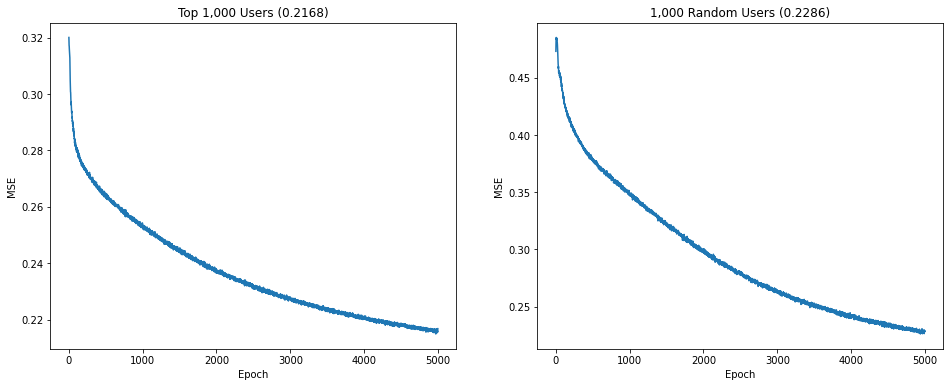

In [25]:
fig = plt.figure(figsize=(16, 6))
titles = ['Top 1,000 Users', '1,000 Random Users']

row = 1
col = 2

for i, d in enumerate(data):
    # Adds a subplot at the 1st position
    fig.add_subplot(row, col, i + 1)
    pd.Series(d['training_result']).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(titles[i] + (' (%.4f)' % (d['training_result'][-1])))

plt.show()

#### Saving the models
Save the models so that it doesn't have to be trained again.

In [26]:
# models will be saved on a .pkl format (pickle files)
filenames = ['./output/top_rbm_model.pkl', './output/random_rbm_model.pkl']

for i in range(len(filenames)):
    pickle.dump(data[i]['model'], open(filenames[i], 'wb'))

In [25]:
# loading the saved RBM model
rbm_models = []
filenames = ['./output/top_rbm_model.pkl', './output/random_rbm_model.pkl']

for filename in filenames:
    rbm_models.append(pickle.load(open(filename, 'rb')))

Instructions for updating:
non-resource variables are not supported in the long term


#### Recommender System Simulation

In [26]:
for i in range(len(rbm_models)):
    _, predicted_recommendations, _ = rbm_models[i].rbm_output(convert_to_normalized_matrix(utility_matrices[i]))
    actual_recommendations = convert_to_recommendation_matrix(utility_matrices[i])
    
    print(np.unique(predicted_recommendations))
    print(np.unique(actual_recommendations))
    print('RMSE: %.4f' % rmse(actual_recommendations, predicted_recommendations))
    print('=' * 20)

[0. 1.]
[-1.  0.  1.]
RMSE: 0.5718
[0. 1.]
[-1.  0.  1.]
RMSE: 0.5825
